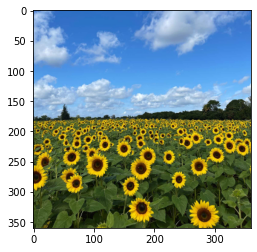

In [17]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import numpy as np

im = cv.imread('./the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
#plot image
plt.imshow(im)

C:\Users\askan\AppData\Local\Temp\ipykernel_13784\2562809574.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


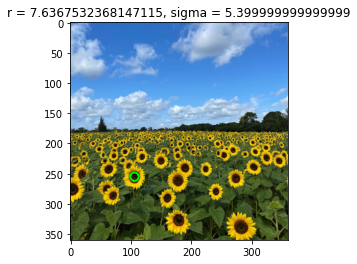

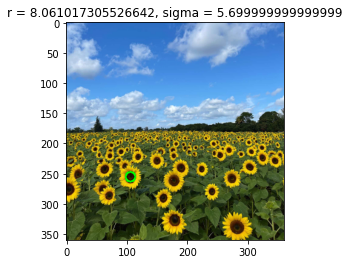

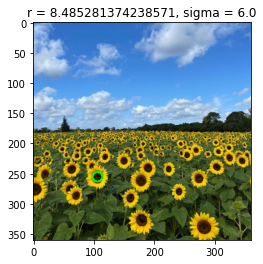

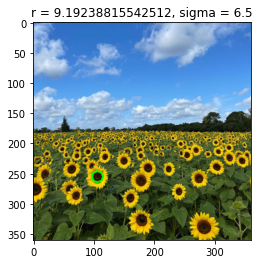

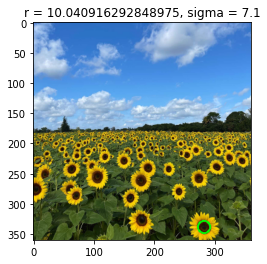

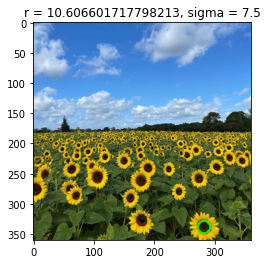

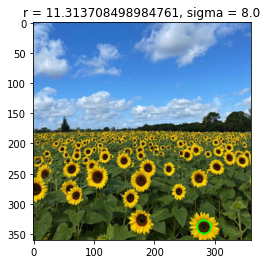

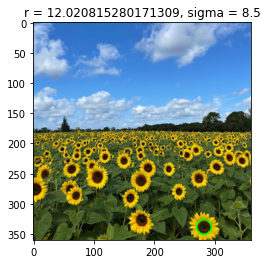

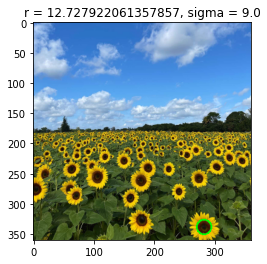

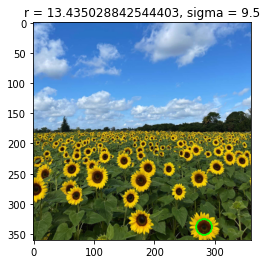

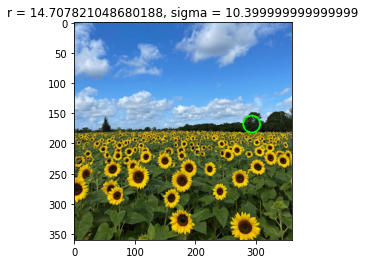

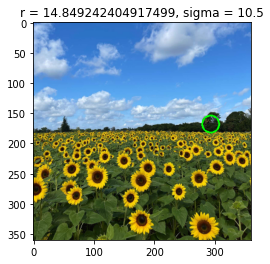

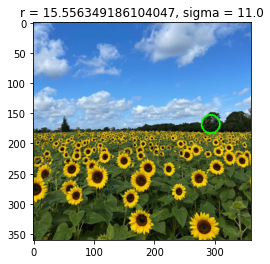

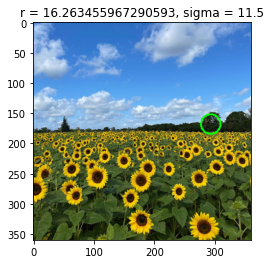

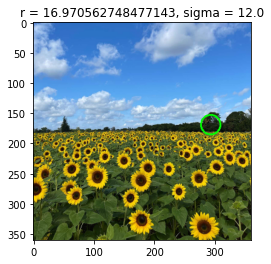

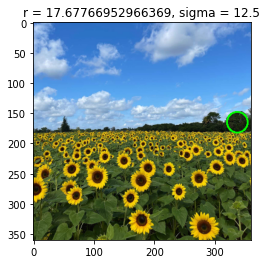

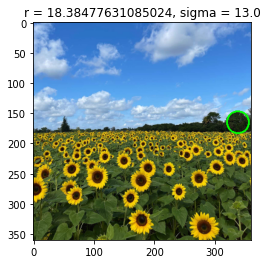

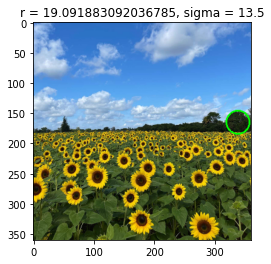

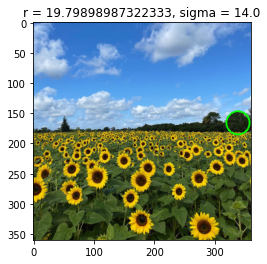

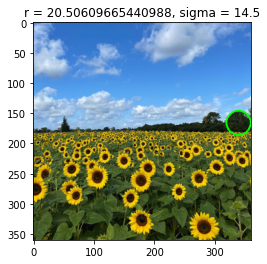

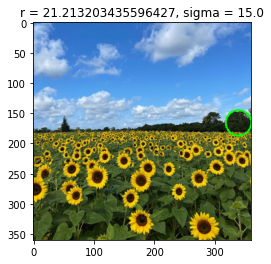

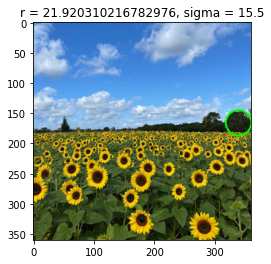

In [18]:
im_gray = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
K = np.arange(5,16,0.5)
for k in K: 
    im_ = im.copy()   
    scale_space = np.empty((im.shape[0] ,im.shape[1] , 500), dtype=np.float64)
    sigmas = np.arange(k,k+0.5, 0.1)
    for i, sigma in enumerate(sigmas):
        log_hw = 3*np.ceil(np.max(sigmas))
        X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
        log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
        f_log = cv.filter2D(im_gray, cv.CV_64F, log)
        scale_space[:, :, i] = f_log

    indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
    r = sigmas[indices[2]]*np.sqrt(2)
    
    #draw a circle around the detected blob
    cv.circle(im_, (int(indices[1]), int(indices[0])), int(r), (0,255,0), 2)
    fig, ax = plt.subplots()
    plt.title('r = ' + str(r) + ', sigma = ' + str(sigmas[indices[2]]))
    plt.imshow(im_)

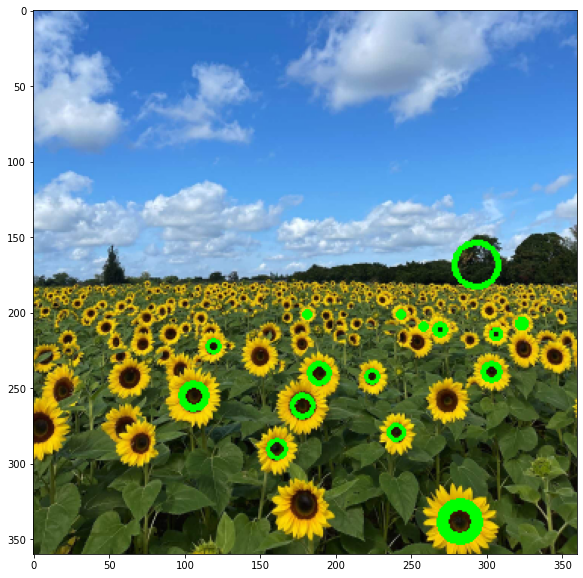

In [19]:
im_gray = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
K = np.arange(1,11,0.1)
for k in K:
    scale_space = np.empty((im.shape[0] ,im.shape[1] , 500), dtype=np.float64)
    sigmas = np.arange(k,k+0.1, 0.01)
    for i, sigma in enumerate(sigmas):
        log_hw = 3*np.ceil(np.max(sigmas))
        X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
        log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
        f_log = cv.filter2D(im_gray, cv.CV_64F, log)
        scale_space[:, :, i] = f_log

    indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
    r = sigmas[indices[2]]*np.sqrt(2)
    
    #draw a circle around the detected blob
    cv.circle(im, (int(indices[1]), int(indices[0])), int(r), (0,255,0), 2)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(im)

# Question 2

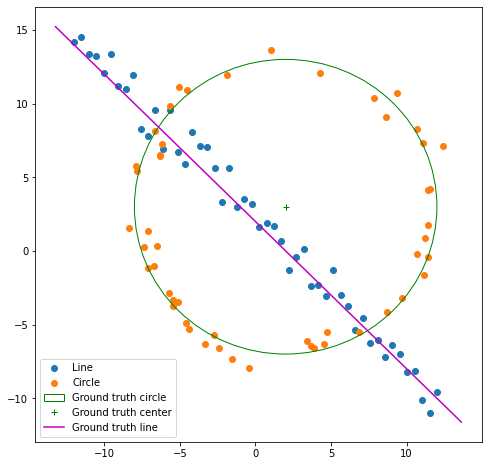

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b0 = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b0 + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

plt.show()


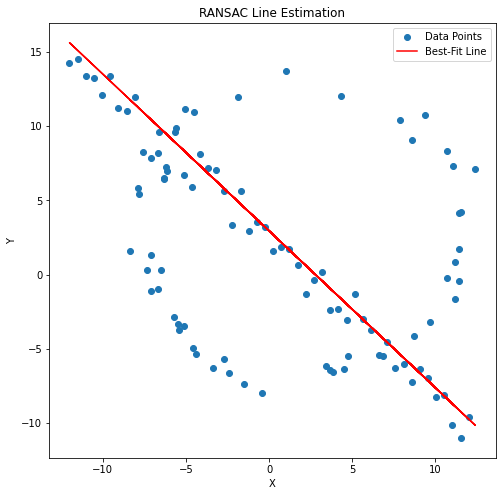

Estimated Line Parameters: a=0.73, b=0.69, d=2.02


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define RANSAC parameters
max_iterations = 10  # Maximum number of iterations
inlier_threshold = 1 # Threshold for inliers (adjust as needed)
min_inliers = 30 # Minimum number of inliers required to fit a model

# Function to estimate the line parameters [a, b]
def estimate_line(points):
    x1, y1, x2, y2 = points[0, 0], points[0, 1], points[1, 0], points[1, 1]
    a = y2 - y1
    b = x1 - x2
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    d = np.abs(x1 * a + y1 * b)  # Perpendicular distance from origin
    return a, b, d

# Function to calculate the error (normal distance to the line)
def line_error(params, points):
    a, b, d = params
    distances = np.abs(points[:, 0] * a + points[:, 1] * b - d)
    return distances


# RANSAC algorithm for line estimation
best_line = None
best_inliers_line = 0

for _ in range(max_iterations):
    # Randomly select two points
    random_indices = np.random.choice(len(X), 2, replace=False)
    random_points = X[random_indices]
    a, b, d = estimate_line(random_points)
    errors = line_error([a, b, d], X)
    inliers = np.sum(errors < inlier_threshold)

    if inliers >= min_inliers and inliers > best_inliers_line:
        best_line = [a, b, d]
        best_inliers_line = inliers

# Plot the data and the estimated line
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], label='Data Points')
plt.plot(X[:, 0], (-X[:, 0] * best_line[0])/ best_line[1] + best_line[2] / best_line[1], 'r', label='Best-Fit Line')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC Line Estimation')
plt.show()

# Print the estimated line parameters
print(f'Estimated Line Parameters: a={best_line[0]:.2f}, b={best_line[1]:.2f}, d={best_line[2]:.2f}')

# Subtract the consensus of the best line (remnant)
line_inliers = X[errors < inlier_threshold]
X_remnant = X[errors >= inlier_threshold]


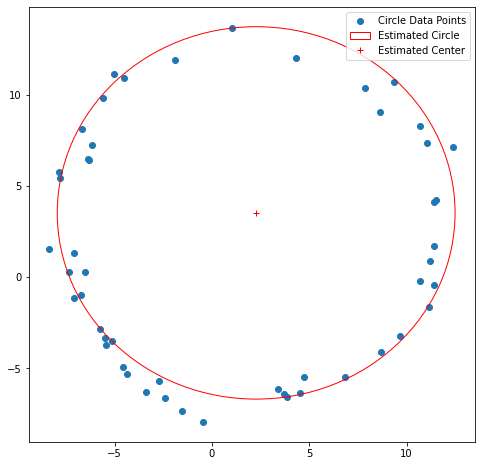

Estimated Circle Parameters: Center ([2.2733512], [3.52525866]), Radius [10.21904368]


In [22]:
from sklearn.metrics import pairwise_distances
np.random.seed(0)

# RANSAC parameters
max_iterations = 100
inlier_threshold = 15 # Adjust this threshold as needed
min_inliers = 10  # Minimum number of inliers required to fit a model

# Function to fit a circle to three points
def fit_circle(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    A = np.array([[x1, y1, 1],
                  [x2, y2, 1],
                  [x3, y3, 1]])
    b = np.array([[-(x1**2 + y1**2)],
                  [-(x2**2 + y2**2)],
                  [-(x3**2 + y3**2)]])
    
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    
    xc = -0.5 * x[0]
    yc = -0.5 * x[1]
    r = np.sqrt((x[0]**2 + x[1]**2) / 4 - x[2])
    
    return xc, yc, r

# RANSAC algorithm for circle estimation
best_circle = None
best_inliers_circle = 0

for _ in range(max_iterations):
    # Randomly select three points
    random_indices = np.random.choice(len(X_circ), 3, replace=False)
    random_points = X_circ[random_indices]
    xc, yc, r = fit_circle(random_points)
    distances = np.sqrt((X_circ[:, 0] - xc)**2 + (X_circ[:, 1] - yc)**2)
    inliers = np.sum(distances < inlier_threshold)

    if inliers >= min_inliers and inliers > best_inliers_circle:
        best_circle = (xc, yc, r)
        best_inliers_circle = inliers

# Plot the data and the estimated circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle Data Points')

if best_circle is not None:
    xc, yc, r = best_circle
    circle_est = plt.Circle((xc, yc), r, color='r', fill=False, label='Estimated Circle')
    ax.add_patch(circle_est)
    plt.plot(xc, yc, '+r', label='Estimated Center')

plt.legend()
plt.show()

# Print the estimated circle parameters
if best_circle is not None:
    print(f'Estimated Circle Parameters: Center ({best_circle[0]}, {best_circle[1]}), Radius {best_circle[2]}')
else:
    print('RANSAC did not find a valid circle.')

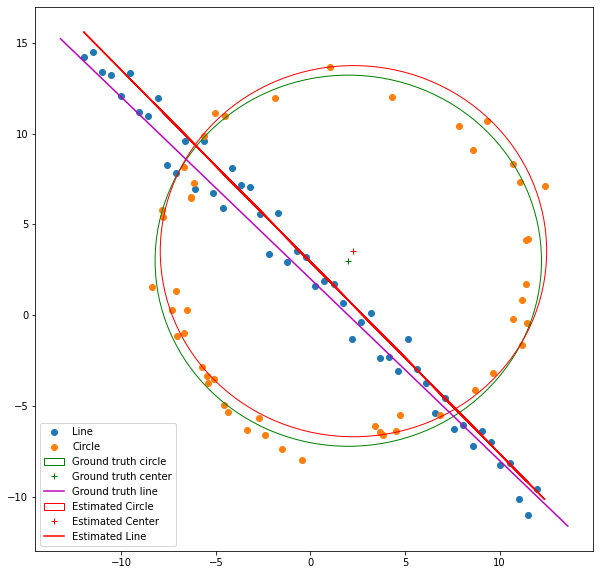

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
plt.plot(x_, y_, color='m', label='Ground truth line')

circle_est = plt.Circle((xc, yc), r, color='r', fill=False, label='Estimated Circle')
ax.add_patch(circle_est)
plt.plot(xc, yc, '+r', label='Estimated Center')

plt.plot(X[:, 0], (-X[:, 0] * best_line[0])/ best_line[1] + best_line[2] / best_line[1], 'r', label='Estimated Line')

plt.legend()
plt.show()

# Question 3

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def measure_images(image_1, image_2):  
    # Find points on the architectural image that correspond to the flag image
    coordinates = []

    # Function to handle mouse events (clicks)
    def click_event(event, x, y, flags, param):
        nonlocal coordinates
        if event == cv.EVENT_LBUTTONDOWN:
            coordinates.append((x, y))
            cv.circle(image_1, (x, y), 5, (0, 0, 255), -1) # Draw a red circle at the clicked point (x, y)
            cv.imshow('Image', image_1) 
            if len(coordinates) == 4:
                cv.destroyAllWindows()

    cv.imshow('Image', image_1)
    cv.setMouseCallback('Image', click_event) # Set the mouse callback function for the 'Image' window

    while len(coordinates) < 4:
        cv.waitKey(1)
        
    image_1_points = np.array(coordinates, dtype=np.float32)

    image_2_width = image_2.shape[1] # Width of the flag image 
    image_2_height = image_2.shape[0] # Height of the flag image
    image_2_points = np.array([[0, 0], [image_2_width, 0], [image_2_width, image_2_height], [0, image_2_height]], dtype=np.float32)
    
    return image_1_points, image_2_points

def superimpose_images(image_1, image_2, image_1_points, image_2_points, alpha , beta):
    homography_matrix= cv.findHomography(image_2_points, image_1_points)[0]

    image_2_warped = cv.warpPerspective(image_2, homography_matrix, (image_1.shape[1], image_1.shape[0]))

    blended_image = cv.addWeighted(image_1, alpha, image_2_warped, beta, 0)
    
    return blended_image

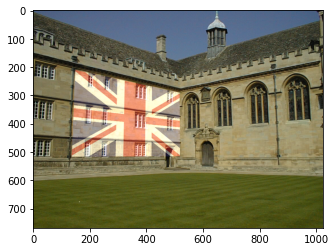

In [25]:
image_1 = cv.imread('./001.jpg', cv.IMREAD_COLOR)
image_2 = cv.imread('./uk_flag.jpg', cv.IMREAD_COLOR)
image_1_points, image_2_points = measure_images(image_1, image_2)
image_1 = cv.imread('./001.jpg', cv.IMREAD_COLOR)
blended_image = superimpose_images(image_1, image_2, image_1_points, image_2_points , 0.9 , 0.45)
 
# Display original images and super imposed image
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))

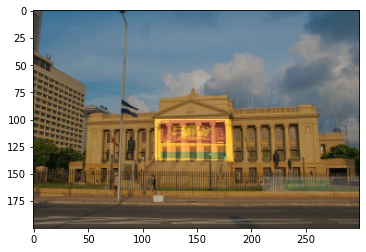

In [26]:
image_1 = cv.imread('./sl_building.jpg' , cv.IMREAD_REDUCED_COLOR_4)
image_2 = cv.imread('./sl_flag.png')
image_1_points, image_2_points = measure_images(image_1, image_2)
image_1 = cv.imread('./sl_building.jpg' , cv.IMREAD_REDUCED_COLOR_4)
blended_image = superimpose_images(image_1, image_2, image_1_points, image_2_points , 0.7 , 0.38)
 
# Display original images and super imposed image
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))

# Question 4

In [27]:
import cv2 as cv

# Load Images
img1 = cv.imread(r'graf/img1.ppm')
img5 = cv.imread(r'graf/img5.ppm')

# Convert to Grayscale
gray1 = cv.cvtColor(img1, cv.IMREAD_COLOR)
gray5 = cv.cvtColor(img5, cv.IMREAD_COLOR)



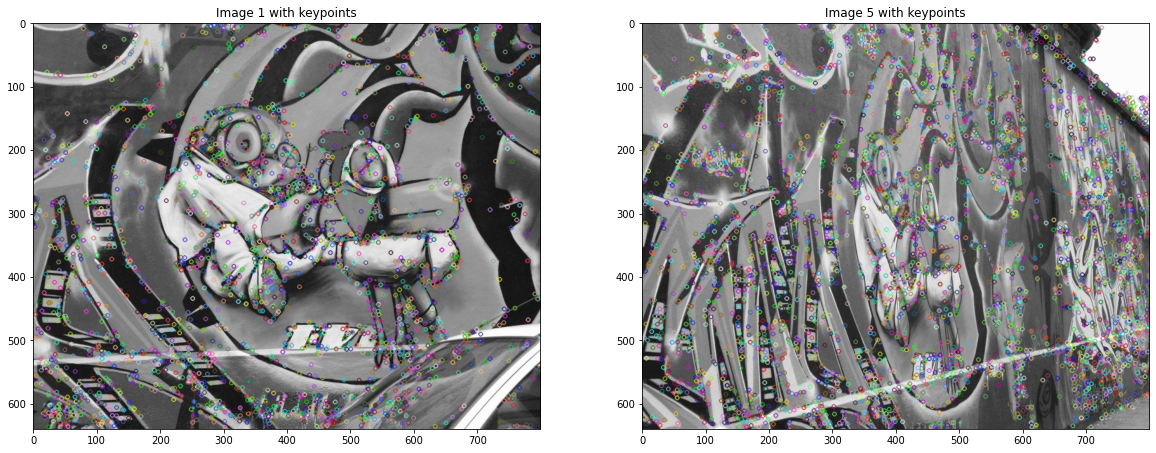

In [28]:
img1 = cv.imread(r'graf/img1.ppm')
img5 = cv.imread(r'graf/img5.ppm')

gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints5, descriptors5 = sift.detectAndCompute(gray5, None)

# Draw keypoints
img1_with_keypoints = cv.drawKeypoints(gray1, keypoints1, img1)
img5_with_keypoints = cv.drawKeypoints(gray5, keypoints5, img5)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(img1_with_keypoints)
plt.title('Image 1 with keypoints')

plt.subplot(1, 2, 2)
plt.imshow(img5_with_keypoints)
plt.title('Image 5 with keypoints')

plt.show()

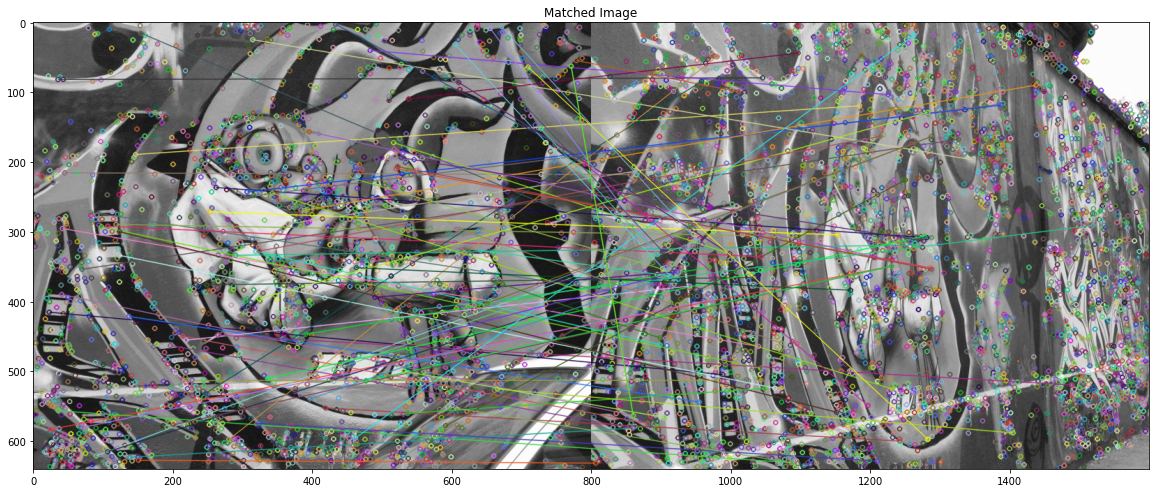

In [29]:
# Create a BFMatcher (Brute Force Matcher) with default parameters
bf = cv.BFMatcher()

# Match descriptors between the two images
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches on a new image
matched_image = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None)

# Plot the matched image
plt.figure(figsize=(20, 20))
plt.imshow(matched_image)
plt.title('Matched Image')
plt.show()

In [30]:
# Custom function to compute the homography matrix using RANSAC 
def compute_homography_RANSAC(matches, keypoints1, keypoints2, num_iterations=1000, threshold=4.0):
    best_homography = None
    best_inliers = []
    
    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        src_points = np.float32([keypoints1[matches[i].queryIdx].pt for i in sample_indices])
        dst_points = np.float32([keypoints2[matches[i].trainIdx].pt for i in sample_indices])
        
        # Compute the homography using the selected correspondences
        homography, _ = cv.findHomography(src_points, dst_points, cv.RANSAC, threshold)
        
        # Calculate the number of inliers
        inliers = []
        for i, match in enumerate(matches):
            src_pt = keypoints1[match.queryIdx].pt
            dst_pt = keypoints2[match.trainIdx].pt
            src_pt_hom = np.array([src_pt[0], src_pt[1], 1.0])
            projected_pt = np.dot(homography, src_pt_hom)
            projected_pt /= projected_pt[2]
            error = np.linalg.norm(np.array([dst_pt[0], dst_pt[1], 1.0]) - projected_pt)
            if error < threshold:
                inliers.append(i)
        
        # Keep the homography with the most inliers
        if len(inliers) > len(best_inliers):
            best_homography = homography
            best_inliers = inliers

    return best_homography, best_inliers

In [31]:
# Compute the homography using RANSAC
best_homography, best_inliers = compute_homography_RANSAC(good_matches, keypoints1, keypoints5)

known_homography = np.array([[6.2544644e-01  ,5.7759174e-02   ,2.2201217e+02],
                    [2.2240536e-01  ,1.1652147e+00  ,-2.5605611e+01],
                    [4.9212545e-04 ,-3.6542424e-05  , 1.0000000e+00]] )

error = np.linalg.norm(known_homography - best_homography)

print("Computed Homography:")
print(best_homography)
print("\nKnown Homography:")
print(known_homography)
print("\nHomography Error:", error)

C:\Users\askan\AppData\Local\Temp\ipykernel_13784\3596145976.py:21: RuntimeWarning: divide by zero encountered in true_divide
  projected_pt /= projected_pt[2]
C:\Users\askan\AppData\Local\Temp\ipykernel_13784\3596145976.py:21: RuntimeWarning: invalid value encountered in true_divide
  projected_pt /= projected_pt[2]


Computed Homography:
[[ 1.62887737e-01 -6.74833839e-01  1.77444390e+02]
 [ 2.25517309e-01 -1.23079252e+00  3.33558720e+02]
 [ 6.85522479e-04 -3.66427744e-03  1.00000000e+00]]

Known Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Homography Error: 361.9278867544344


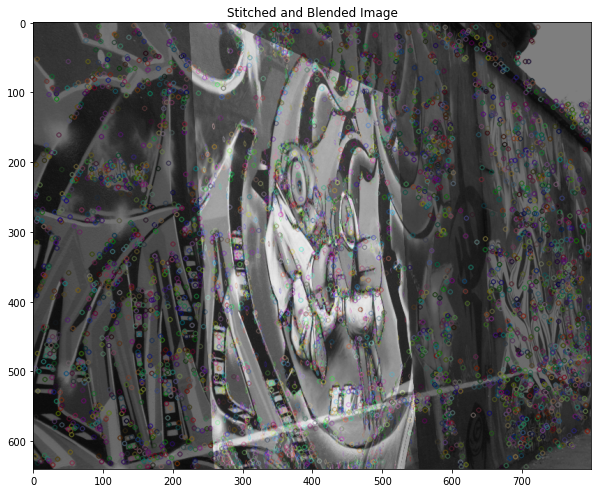

In [32]:
stitched_image = cv.warpPerspective(img1, known_homography, (img5.shape[1], img5.shape[0]))

alpha = 0.5  # Adjust the alpha value for different blending effects
beta = 1.0 - alpha
blended_image = cv.addWeighted(stitched_image, alpha, img5, beta, 0.0)

plt.figure(figsize=(10, 10))
plt.imshow(blended_image)
plt.title('Stitched and Blended Image')
plt.show()